In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.fft import fft
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

scaler = StandardScaler()

# Load CSVs
df_Normal = pd.read_csv("./IMUDatasets/Normal/Normal_5_16G.csv")
df_Outer = pd.read_csv("./IMUDatasets/Outer/Outer_5_16G.csv")
df_InnerRail = pd.read_csv("./IMUDatasets/Inner/Inner_5_16G.csv")
df_Gun = pd.read_csv("./IMUDatasets/Cage/Cage_5_16G.csv")




             x       y       z
0      -0.0449 -0.0947  1.8916
1       0.1025 -0.1387  1.8906
2       0.1055  0.0156  2.0000
3      -0.2598 -0.0850  1.9639
4       0.0957 -0.0059  1.9648
...        ...     ...     ...
226776  0.1602  0.0352  2.0381
226777 -0.4824 -0.3975  1.9512
226778 -0.1562 -0.1289  1.7520
226779  0.0635 -0.0059  2.1279
226780 -0.1826 -0.0645  1.8564

[226781 rows x 3 columns]
[-0.01046191 -0.03479379  1.977515  ] [0.20653662 0.13225297 0.14808142]
(3628, 250, 3) (3628, 4)
(1087, 250, 3) (1087, 4)
(2540, 250, 3) (2540, 4)
[[0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


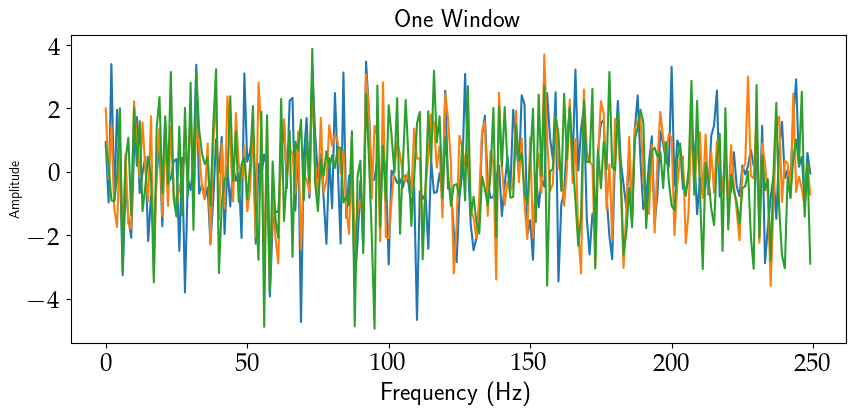

In [16]:
from tensorflow.keras.utils import to_categorical
from scipy.fft import fft

window_size = 250
#Windowing 
def create_windows(df, window_size):
    sequences = []
    for i in range(int(len(df)/window_size)):
        window = df[i*window_size:(i+1)*window_size]
        sequences.append(window)
    # sequences = np.expand_dims(sequences, axis = -1)
    return np.array(sequences)

def create_1_window(df,window_size,start):
    window = []
    window.append(df[start*window_size:(start+1)*window_size])
    return np.array(window)

window = 250

print(df_InnerRail)

df_Normal = np.array(df_Normal)
df_Outer = np.array(df_Outer)
df_InnerRail = np.array(df_InnerRail)
df_Gun = np.array(df_Gun)

df_scale = np.concatenate([df_Normal,df_Outer,df_InnerRail,df_Gun], axis = 0)
df_scale = scaler.fit(df_scale)

df_Normal = df_scale.transform(df_Normal)
df_Outer = df_scale.transform(df_Outer)
df_InnerRail = df_scale.transform(df_InnerRail)
df_Gun = df_scale.transform(df_Gun)

means = scaler.mean_        # Mean of each feature (1D array)
stds = scaler.scale_        # Standard deviation of each feature (1D array)

print(means, stds)

X_N = create_windows(df_Normal, window_size)
X_O = create_windows(df_Outer, window_size)
X_I = create_windows(df_InnerRail, window_size)
X_G = create_windows(df_Gun, window_size)

Y_N = np.zeros(len(X_N)) #Combine the labels then
Y_O = np.ones(len(X_O))
Y_I = np.full(len(X_I), 2)
Y_G = np.full(len(X_G), 3)

Y = np.concatenate([Y_N,Y_O,Y_I,Y_G], axis=0)
Y = to_categorical(Y, num_classes = 4)

X = np.concatenate([X_N,X_O,X_I,X_G], axis = 0)

print(X.shape,Y.shape)
X,Y = shuffle(X,Y)

def perc_10(dataset):
    return int(0.3 * len(dataset))

X_test, Y_test = X[:(perc_10(X)-1)], Y[:(perc_10(Y)-1)]

X, Y = X[perc_10(X):], Y[perc_10(Y):]

print(X_test.shape,Y_test.shape)
print(X.shape,Y.shape)
print(Y)

Display_X = np.squeeze(X[:1], axis=0)
Display_X = pd.DataFrame(Display_X)

fontsize = 18
plt.figure(figsize=(10, 4))
plt.plot(Display_X)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.title("One Window",fontsize = fontsize)
plt.xlabel("Frequency (Hz)",fontsize = fontsize)
plt.ylabel("Amplitude")
plt.grid(False)
plt.show()

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

X, Y = shuffle(X,Y)

X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y, test_size=0.2
)

print(X_train.shape,Y_train.shape)

(2032, 250, 3) (2032, 4)


In [18]:
import tensorflow as tf
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True) #Multi Classifier with Logits

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(250, 3, 1)),

    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.AveragePooling2D(),
    tf.keras.layers.GlobalAveragePooling2D(), 
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(4, activation=None)
])

model.compile(
    optimizer='adam',
    loss=loss,
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 250, 3, 16)        160       
                                                                 
 conv2d_3 (Conv2D)           (None, 250, 3, 16)        2320      
                                                                 
 average_pooling2d_1 (Averag  (None, 125, 1, 16)       0         
 ePooling2D)                                                     
                                                                 
 global_average_pooling2d_1   (None, 16)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 4)                

In [19]:
history = model.fit(
    X_train,
    Y_train,
    epochs= 75,
    batch_size=128,
    validation_data = (X_val,Y_val),
    shuffle=True,
    verbose = 0
)


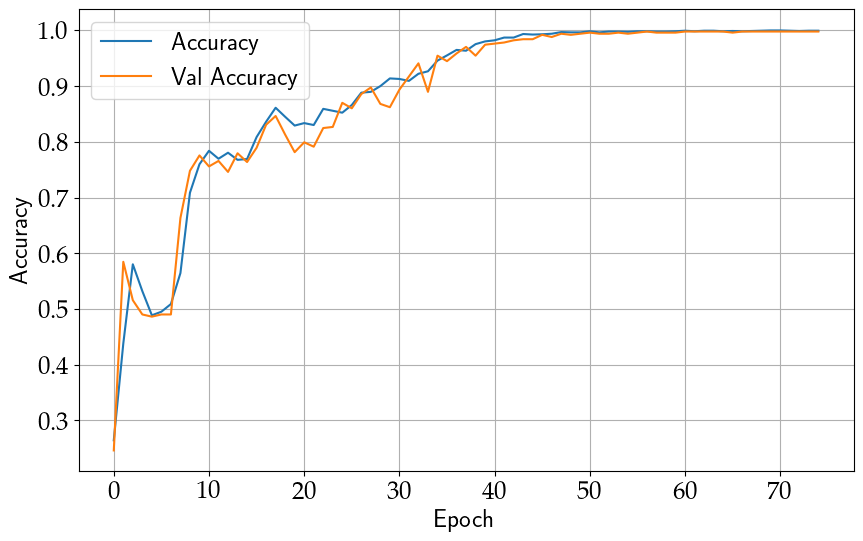

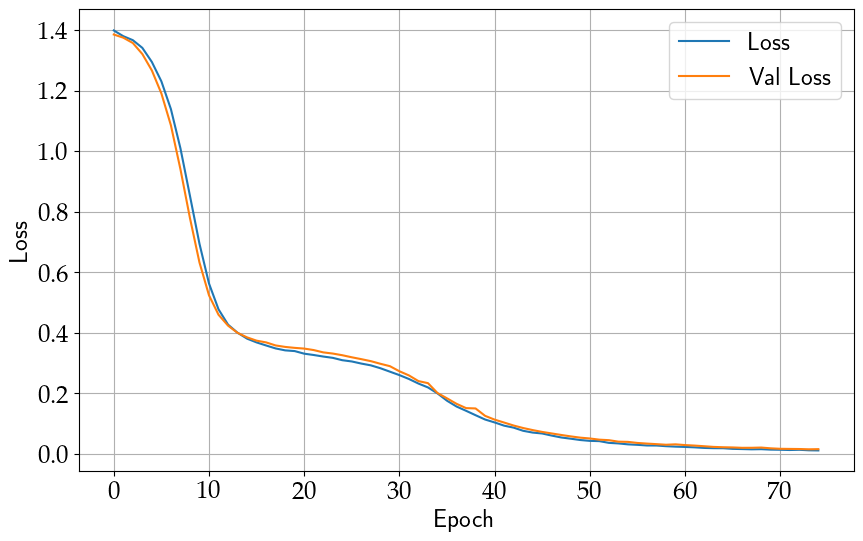

In [24]:
import matplotlib.pyplot as plt

plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{mathpazo}"

fontsize = 18
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'][0:200], label='Accuracy')
plt.plot(history.history['val_accuracy'][0:200], label='Val Accuracy')
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel('Epoch', fontsize = fontsize)
plt.ylabel('Accuracy', fontsize = fontsize)
plt.legend(fontsize = fontsize)
plt.grid(True)
plt.savefig('./graphs/Accuracy.svg', format='svg')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'][0:200], label='Loss')
plt.plot(history.history['val_loss'][0:200], label='Val Loss')
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel('Epoch', fontsize = fontsize)
plt.ylabel('Loss', fontsize = fontsize)
plt.legend(fontsize = fontsize)
plt.grid(True)
plt.savefig('./graphs/Loss.svg', format='svg')
plt.show()

In [25]:
from sklearn.utils import shuffle
import tensorflow as tf
import matplotlib.pyplot as plt

X_test,Y_test = shuffle(X_test,Y_test)

print(X_test.shape)
y_pred_scores = model.predict(X_test)

test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print("Test Accuracy:", test_accuracy)

(1087, 250, 3)
34/34 [==============================] - 0s 3ms/step - loss: 0.0153 - accuracy: 0.9982
Test Accuracy: 0.9981600642204285


(1087, 4)
Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       248
       Outer       1.00      1.00      1.00       283
   InnerRail       1.00      0.99      1.00       287
         Gun       0.99      1.00      1.00       269

    accuracy                           1.00      1087
   macro avg       1.00      1.00      1.00      1087
weighted avg       1.00      1.00      1.00      1087



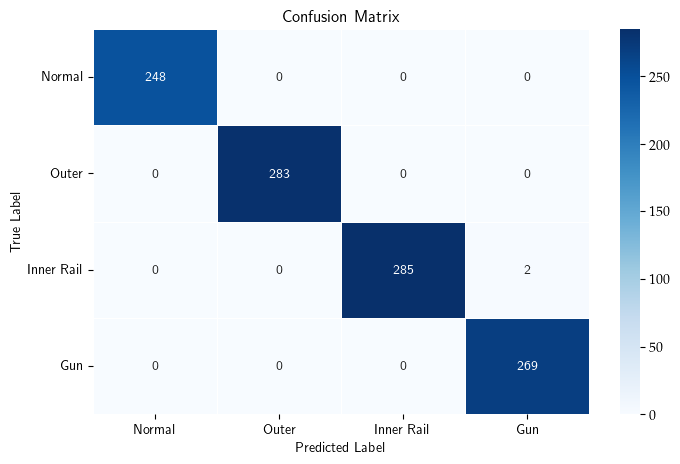

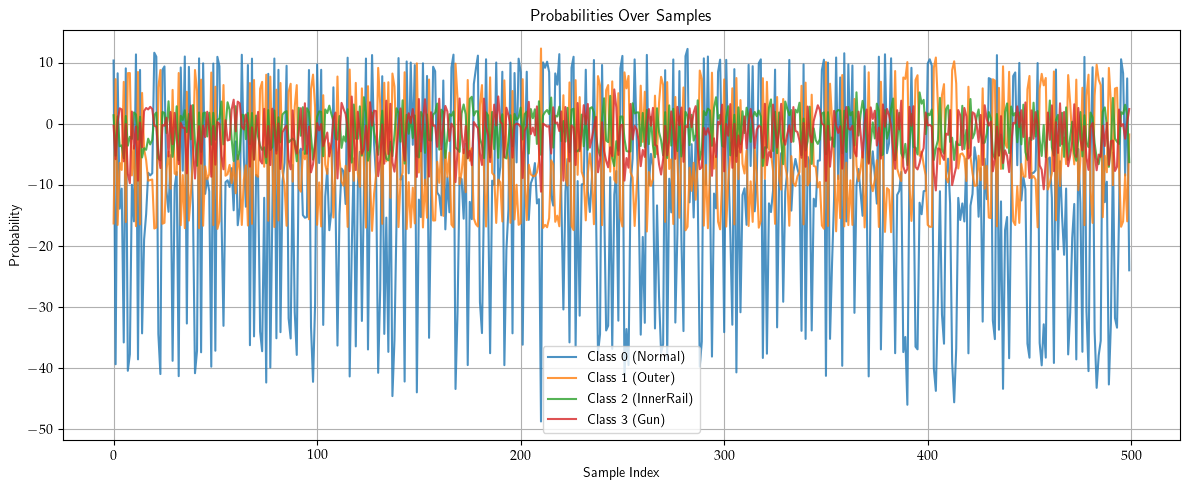

In [26]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print(Y_test.shape)
y_pred_labels = np.argmax(y_pred_scores, axis=1)
y_true_labels = np.argmax(Y_test, axis = 1)

# Evaluate
print("Confusion Matrix:")

print("\nClassification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=["Normal","Outer","InnerRail","Gun"]))

amount_start = 0
amount_to_show = 500

plt.figure(figsize=(8,5))
sns.heatmap(confusion_matrix(y_true_labels, y_pred_labels), annot=True, fmt='d', cmap='Blues', cbar=True, linewidths=0.5,linecolor='white')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=['Normal', 'Outer', 'Inner Rail', 'Gun'])
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=['Normal', 'Outer', 'Inner Rail', 'Gun'], rotation=0)
plt.savefig('./graphs/Confusion_Matrix.svg', format='svg')
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(y_pred_scores[amount_start:amount_to_show, 0], label="Class 0 (Normal)", alpha=0.8)
plt.plot(y_pred_scores[amount_start:amount_to_show, 1], label="Class 1 (Outer)", alpha=0.8)
plt.plot(y_pred_scores[amount_start:amount_to_show, 2], label="Class 2 (InnerRail)", alpha=0.8)
plt.plot(y_pred_scores[amount_start:amount_to_show, 3], label="Class 3 (Gun)", alpha=0.8)

plt.title("Probabilities Over Samples")
plt.xlabel("Sample Index")
plt.ylabel("Probability")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

(1087, 250, 3)
34/34 [==============================] - 0s 3ms/step


C:\Users\calib\anaconda3\envs\tf\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\calib\anaconda3\envs\tf\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


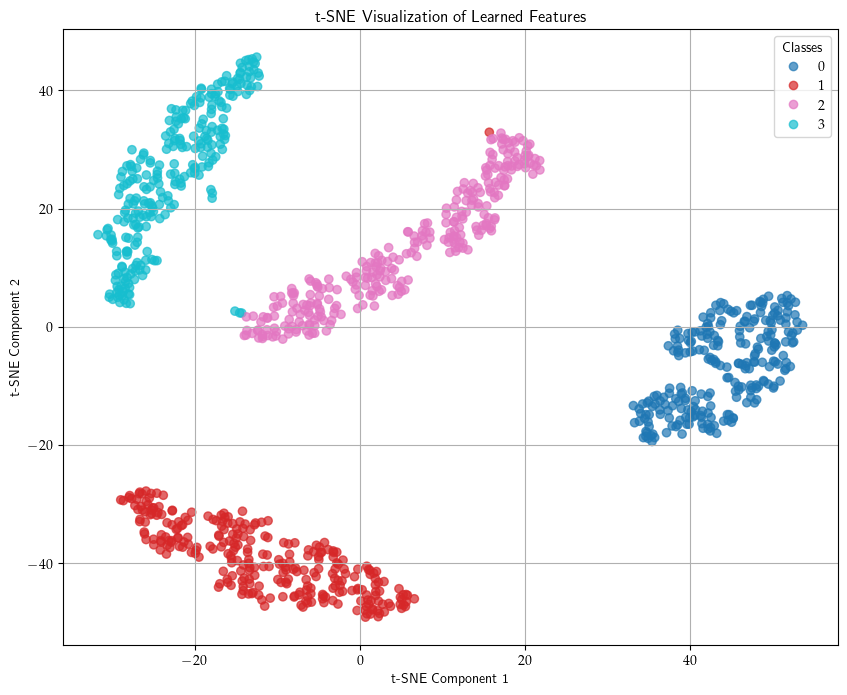

In [27]:
from tensorflow.keras.models import Model

# Suppose `model` is your trained Keras model
# You get the output from the layer before the final Dense layer
feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)

print(X_test.shape)
features = feature_extractor.predict(X_test) #test dataset

labels = Y_test #get your labels

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_2d = tsne.fit_transform(features)

import matplotlib.pyplot as plt
import numpy as np

#For onehot encoding conversion
if labels.ndim > 1:
    labels = np.argmax(labels, axis=1)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Classes")

plt.title("t-SNE Visualization of Learned Features")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(True)
plt.savefig('./graphs/T_SNE.svg', format='svg')
plt.show()

In [28]:
model.save("./fin_models/4Classes_Model.h5")

In [1]:
#Quantizing Process

X = shuffle(X)

# Representative dataset for quantization
def representative_dataset():
    for i in range(600):
        sample = X[i]
        # print(X[i].shape)
        sample = np.expand_dims(sample, axis=0)
        sample = np.expand_dims(sample, axis=3)
        # print(sample.shape)
        yield [sample.astype(np.float32)]

# Convert model
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]   #This causes the weights and activations to become int8

converter.experimental_new_quantizer = False #enable for per-axis quantizing

converter._experimental_lower_tensor_list_ops = False

converter.representative_dataset = representative_dataset   #Scaling of quantizing

converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32

tflite_model = converter.convert()

# Save the TFLite model
with open('tflite_models/4Classes.tflite', 'wb') as f:
    f.write(tflite_model)

NameError: name 'shuffle' is not defined

In [30]:
import tensorflow as tf

# Load your TFLite model
interpreter = tf.lite.Interpreter(model_path="tflite_models/4Classes.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
tensor_details = interpreter.get_tensor_details()

print("== Input Details ==")
for detail in input_details:
    print(f"Name: {detail['name']}, Type: {detail['dtype']}, Shape: {detail['shape']}")
    print(f"Quantization: {detail['quantization']}")

print("\n== Output Details ==")
for detail in output_details:
    print(f"Name: {detail['name']}, Type: {detail['dtype']}, Shape: {detail['shape']}")
    print(f"Quantization: {detail['quantization']}")

print("\n== Quantized Tensors ==")
for tensor in tensor_details:
    if tensor['quantization'] != (0.0, 0):
        print(f"Name: {tensor['name']}, Type: {tensor['dtype']}, Quantization: {tensor['quantization']}")

== Input Details ==
Name: serving_default_input_2:0, Type: <class 'numpy.float32'>, Shape: [  1 250   3   1]
Quantization: (0.0, 0)

== Output Details ==
Name: StatefulPartitionedCall:0, Type: <class 'numpy.float32'>, Shape: [1 4]
Quantization: (0.0, 0)

== Quantized Tensors ==
Name: serving_default_input_2:0_int8, Type: <class 'numpy.int8'>, Quantization: (0.05359405279159546, 12)
Name: sequential_1/dense_3/BiasAdd/ReadVariableOp, Type: <class 'numpy.int32'>, Quantization: (0.0014404505491256714, 0)
Name: sequential_1/dense_2/BiasAdd/ReadVariableOp, Type: <class 'numpy.int32'>, Quantization: (0.0006796461530029774, 0)
Name: sequential_1/dense_2/MatMul, Type: <class 'numpy.int8'>, Quantization: (0.009367317892611027, 0)
Name: sequential_1/dense_3/MatMul, Type: <class 'numpy.int8'>, Quantization: (0.010684100911021233, 0)
Name: sequential_1/conv2d_2/Relu;sequential_1/conv2d_2/BiasAdd;sequential_1/conv2d_3/Conv2D;sequential_1/conv2d_2/Conv2D;sequential_1/conv2d_2/BiasAdd/ReadVariableOp, 

In [31]:
import tensorflow as tf

interpreter = tf.lite.Interpreter(model_path="./tflite_models/4Classes.tflite")
interpreter.allocate_tensors()
details = interpreter.get_tensor_details()

for op in interpreter._get_ops_details():
    print(op['op_name'])

QUANTIZE
CONV_2D
CONV_2D
AVERAGE_POOL_2D
MEAN
FULLY_CONNECTED
FULLY_CONNECTED
DEQUANTIZE
DELEGATE
DELEGATE
